Custom dataset


In [1]:
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader,random_split
from torchvision import transforms


c:\Users\maha9\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CustomDataset(Dataset):
    def __init__(self,root_dir,transform=None):
      
        self.root_dir=root_dir
        self.transform=transform
        self.file_paths=[]
        self.class_names=sorted(os.listdir(root_dir))

        for class_name in self.class_names:
            class_path=os.path.join(self.root_dir,class_name)
            files=[os.path.join(class_path, file) for file in os.listdir(class_path)]
            self.file_paths.extend(files)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self,idx):
        img_path=self.file_paths[idx]
        image=Image.open(img_path)

        if self.transform:
            image=self.transform(image)

        class_name=os.path.basename(os.path.dirname(img_path))
        label_idx=torch.tensor(self.class_names.index(class_name),dtype=torch.long)

        return image,label_idx,class_name

In [3]:
transform=transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])

In [4]:
dataset=CustomDataset(root_dir=r"D:\documents\datasets\plants\Bell Pepper\Train",transform=transform)

In [6]:
print("Length of dataset:",len(dataset))
train_size=int(0.8*len(dataset))
test_size=len(dataset)-train_size
train_dataset,test_dataset=random_split(dataset,[train_size,test_size])

Length of dataset: 3901


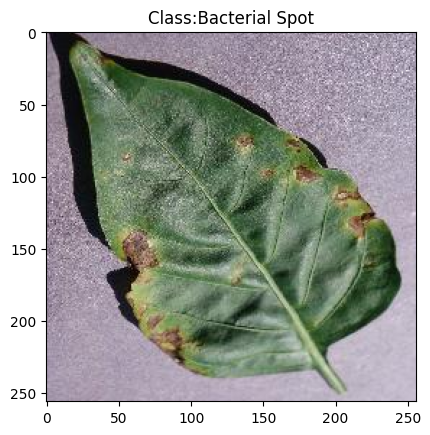

In [7]:
index=1
img,label_idx,label_name=dataset[index]

plt.imshow(img.permute(1,2,0))  #PyTorch uses(C,H,W),so permute dimensions
plt.title("Class:"+str(label_name))
plt.show()

MLP for MNIST dataset

In [1]:
import os
import torchvision
import pandas as pd
from torchvision.io import read_image
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import transforms, utils,datasets
import matplotlib.pyplot as plt

In [2]:
t=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

In [3]:
train=datasets.MNIST(root='./data',train=True,download=True,transform=t)
test=datasets.MNIST(root='./data',train=False,download=True,transform=t)


In [4]:
train.targets[5]

tensor(2)

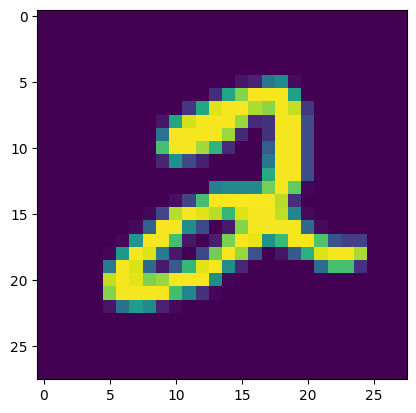

In [5]:
import numpy as np
plt.imshow(train.data[5].numpy())

In [6]:
total_len=len(train)
training_size=int(0.8*total_len)
valid_size=int(0.2*total_len)
print(training_size,valid_size)
trainSet,valSet=random_split(train,[training_size,valid_size])

48000 12000


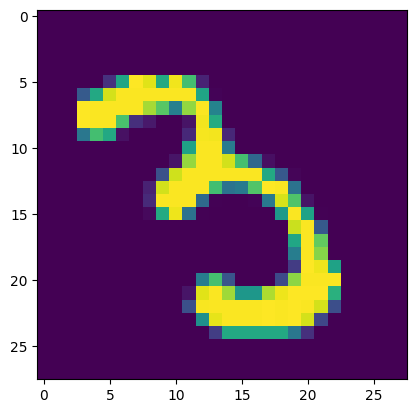

In [7]:
plt.imshow(trainSet[0][0].squeeze().numpy())
plt.show()

In [8]:
train_loader = DataLoader(trainSet, batch_size=64, shuffle=True)
val_loader = DataLoader(valSet, batch_size=64, shuffle=False)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

In [9]:
dataiter = iter(train_loader)
for images, labels in dataiter:
    print(images.shape, labels.shape)
    print(labels)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])
tensor([7, 0, 2, 4, 1, 0, 5, 5, 1, 2, 8, 7, 0, 6, 4, 1, 7, 8, 3, 7, 1, 3, 1, 8,
        3, 1, 7, 6, 3, 4, 7, 2, 3, 5, 9, 9, 3, 3, 8, 6, 1, 5, 3, 0, 2, 7, 0, 6,
        7, 9, 5, 7, 7, 8, 8, 8, 6, 5, 5, 8, 2, 7, 2, 9])


In [10]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [11]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
import torch
trainloss=[]
valoss=[]
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        #print(labels.size())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            vloss = criterion(outputs, labels)
            val_loss +=criterion(outputs, labels).item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}")
    trainloss.append(loss.data)
    valoss.append(vloss.data)

Epoch 1/5, Validation Loss: 0.1712
Epoch 2/5, Validation Loss: 0.1357
Epoch 3/5, Validation Loss: 0.1441
Epoch 4/5, Validation Loss: 0.1245
Epoch 5/5, Validation Loss: 0.1060


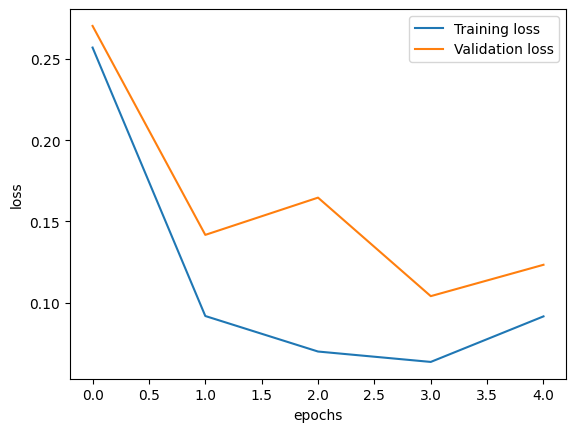

In [15]:
import matplotlib.pyplot as plt
plt.plot(trainloss,label="Training loss")
plt.plot(valoss,label="Validation loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [16]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print("Accuracy : ",correct/total)
torch.save(model.state_dict(), 'handwritten_digit_model.pth')
print("Model saved as 'handwritten_digit_model.pth'")

Accuracy :  0.9701
Model saved as 'handwritten_digit_model.pth'
